In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
import collections
import numpy as np

## task 01

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [2]:
# класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = collections.Counter()
        for label in self.labels:
            classes[label] += 1
            
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [4]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = collections.Counter()
    for label in labels:
        classes[label] += 1    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [5]:
# энтропия Шеннона
def shannon(labels):
    #  подсчет количества объектов разных классов
    classes = collections.Counter()
    for label in labels:
        classes[label] += 1    
    #  расчет критерия
    vals = np.array(list(classes.values()))
    probs = vals/vals.sum()
    impurity = -1 * (probs * np.log2(probs)).sum()
        
    return impurity

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_criteria, criteria):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
#     return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return current_criteria - p * criteria(left_labels) - (1 - p) * criteria(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criteria): 
    # минимальное количество объектов в узле
    min_leaf = 5
    
    current_criteria = criteria(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criteria, criteria)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [9]:
# find_best_split(train_data, train_labels, shannon)

In [10]:
# find_best_split(train_data, train_labels, gini)

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criteria, max_depth, depth=0):
    if depth < max_depth: # критерий остановки по максимальной глубине дерева
        quality, t, index = find_best_split(data, labels, criteria)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        depth +=1
        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, criteria, max_depth, depth)
        false_branch = build_tree(false_data, false_labels, criteria, max_depth, depth)
        

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    else:
        return Leaf(data, labels)

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [15]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    return (actual == predicted).sum() / float(len(actual)) * 100.0

In [16]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 1000,
                                                                          n_features = 2, 
                                                                          n_informative = 2, 
                                                                          n_classes = 2, 
                                                                          n_redundant = 0, 
                                                                          n_clusters_per_class = 1, 
                                                                          random_state = 5)

In [39]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.25,
                                                                                     random_state = 1)

In [40]:
# Построим дерево по обучающей выборке
my_tree_shannon = build_tree(train_data, train_labels, shannon, max_depth = 5)
my_tree_gini = build_tree(train_data, train_labels, gini, max_depth = 5)

In [41]:
# print_tree(my_tree_gini)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6727874248522925
    --> True:
      Индекс 0
      Порог -0.8637065067732941
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.40118216125291906
      --> True:
        Индекс 1
        Порог -1.5684737117409848
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Индекс 1
        Порог -1.536151890760579
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 1
  Порог -1.4518330557811816
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.08948763365897339
    --> True:
      Индекс 0
      Порог 0.04459943514365716
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0
      Порог 2.16476189691063
      --> True:
    

In [42]:
# Получим ответы для обучающей выборки 
train_answers_shannon = predict(train_data, my_tree_shannon)
train_answers_gini = predict(train_data, my_tree_gini)

In [43]:
# И получим ответы для тестовой выборки
answers_shannon = predict(test_data, my_tree_shannon)
answers_gini = predict(test_data, my_tree_gini)

In [44]:
# Точность на обучающей выборке
train_accuracy_shannon = accuracy_metric(train_labels, train_answers_shannon)
train_accuracy_shannon

97.06666666666666

In [45]:
# Точность на обучающей выборке
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_gini

97.2

In [46]:
# Точность на тестовой выборке
test_accuracy_shannon = accuracy_metric(test_labels, answers_shannon)
test_accuracy_shannon

96.8

In [47]:
# Точность на тестовой выборке
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_gini

97.2

При данных параметрах точность на тесте выше у модели, использующей критерий Джини. При другом выборе параметров ситуация может меняться

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Test accuracy (Gini)=97.20')

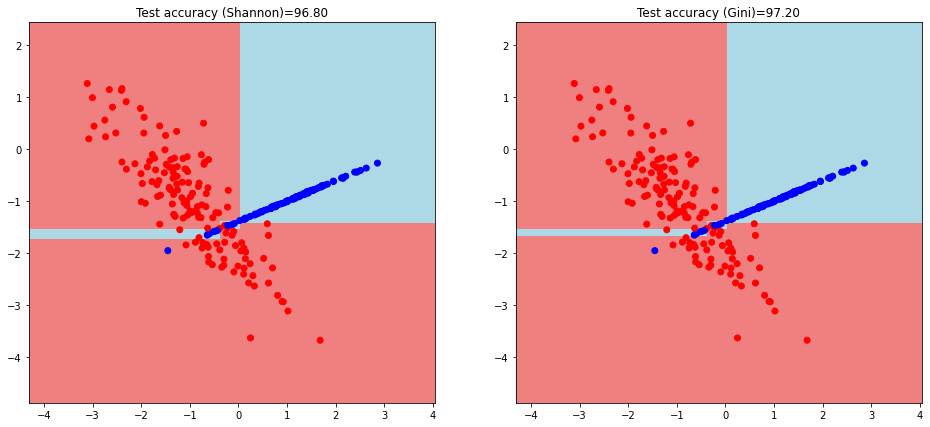

In [48]:
# Визуализируем дерево на графике
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))
xx, yy = get_meshgrid(test_data)

# график test shannon
plt.subplot(1,2,1)

mesh_predictions_shannon = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_shannon)).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions_shannon, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy (Shannon)={test_accuracy_shannon:.2f}')

# график test gini
plt.subplot(1,2,2)
mesh_predictions_gini = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions_gini, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy (Gini)={test_accuracy_gini:.2f}')

In [27]:
a = np.array([0, 1, 1, 0, 0, 0, 0, 1])
b = np.array([0, 1, 1, 1, 1])

In [28]:
shannon(b)

0.7219280948873623

In [29]:
c = np.array(list(classes.values()))
p = c/c.sum()
p

NameError: name 'classes' is not defined

In [ ]:
-1 * (p * np.log2(p)).sum()

In [ ]:
np.array([4, 4])/2

In [ ]:
gini2(a)